In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Import MNIST Dataset
from tensorflow.keras.datasets import mnist

from customnet import CustomNet

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg') # Non-interactive

import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import numpy as np
from imutils import paths, resize
import cv2
import os

## Network architecture

In [37]:
net = CustomNet()
# MNIST (h, w, d) = (28, 28, 1)
model = net.build(28, 28, num_classes=10, depth=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_25 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)       

## Loading, processing and splitting the dataset

In [38]:
print('# Loading MNIST dataset...')
(trainX, trainY), (testX, testY) = mnist.load_data()
print('# MNIST dataset loaded!')

# Loading MNIST dataset...
# MNIST dataset loaded!


In [39]:
# w/h used as a final input size
target_size = 28

def preprocess(image):
    ''' Preprocess an image (resizeing, extracting patches/crops...) '''
    if image is not None:
        # Extract a random crop from the image
        try:
            image = extract_patches_2d(
                image,
                (target_size, target_size),
                max_patches=1
            )[0]
        except Exception:
            pass
        # Transform image to array
        image = img_to_array(image, data_format=None)
        # Send back the image
        return image

# Normalize [0, 1] => numpy array
trainX = np.array([preprocess(image) for image in trainX]).astype('float') / 255.0
print('Num training images:', len(trainX))
testX = np.array([preprocess(image) for image in testX]).astype('float') / 255.0
print('Num test images:', len(testX))

Num training images: 60000
Num test images: 10000


## Labels one-hot encoding

In [40]:
trainY = to_categorical(trainY, num_classes=10)
testY = to_categorical(testY, num_classes=10)

## Data Augmentation

In [41]:
daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

## Train the network

In [42]:
num_epochs = 50

### Polynomial decay

$$\alpha = \alpha_{0} * (1 - e / e_{\max})^{^{p}}$$

In [43]:
init_lr = 5e-3

def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 2.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

In [44]:
# Save best weights based on validation loss
checkpointHandler = ModelCheckpoint(
    'best_c10_weights.hdf5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    LearningRateScheduler(polynomial_decay),
    checkpointHandler
]

In [45]:
# sgd_opt = SGD(lr=init_lr, momentum=0.9)
adam_opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# Compile the model
print('# Compiling the model...')
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
# Train the network!
print('# Training the network...')
h = model.fit_generator(
    daug.flow(trainX, trainY, batch_size=128),
    validation_data=(testX, testY),
    epochs=num_epochs,
    steps_per_epoch=len(trainX) // 128,
    callbacks=callbacks,
    verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/50
467/468 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9440
Epoch 00001: val_loss improved from inf to 11.49225, saving model to best_c10_weights.hdf5
468/468 [==============================] - 45s 96ms/step - loss: 0.1875 - acc: 0.9440 - val_loss: 11.4923 - val_acc: 0.1093
Epoch 2/50
467/468 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9767
Epoch 00002: val_loss improved from 11.49225 to 0.05709, saving model to best_c10_weights.hdf5
468/468 [==============================] - 40s 87ms/step - loss: 0.0761 - acc: 0.9767 - val_loss: 0.0571 - val_acc: 0.9826
Epoch 3/50
467/468 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9826
Epoch 00003: val_loss improved from 0.05709 to 0.05332, saving model to best_c10_weights.hdf5
468/468 [==============================] - 41s 87ms/step - loss: 0.0589 - acc: 0.9826 - val_loss: 0.0533 - val_acc: 0.9852
Epoch 4/50
467/468 [======

## Evalute the network

In [46]:
# Set labels names for easier reading
label_names = [
    'Zero',
    'One',
    'Two',
    'Three',
    'Four',
    'Five',
    'Six',
    'Seven',
    'Eight',
    'Nine'
]

# Evalutate the network
print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

# Trained the network! Evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



## Plot curves

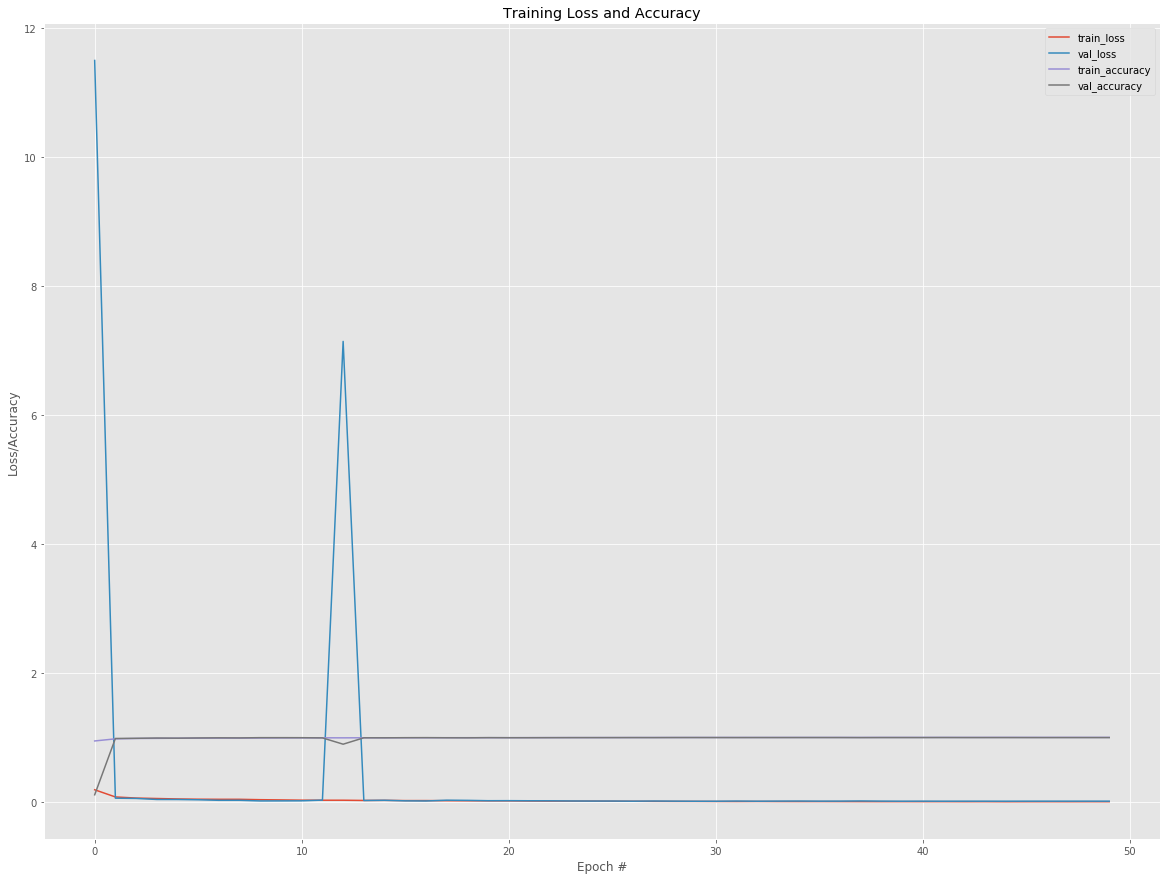

In [47]:
%matplotlib inline
plt.style.use('ggplot')
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()

In [48]:
test = pd.read_csv("test.csv")
test = test / 255.0
test = test.values.reshape(-1,28,28,1)
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)
print("Saved!")

Saved!
